In [1]:
from __future__ import absolute_import
from __future__ import print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from pickle import dump
from keras.preprocessing.image import ImageDataGenerator
import os
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
import sys
import io
from keras.initializers import RandomNormal
import numpy as np
from keras.layers import Input, Dense,Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D,Conv2DTranspose,Dropout, ELU
from keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import keras
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
import keras.layers as KL
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from keras.models import model_from_json
from sklearn.utils import shuffle
from sklearn.metrics import jaccard_similarity_score
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from PIL import Image
from os import walk
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.models import Model
from keras.utils import np_utils
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras import backend as K
from keras.applications import imagenet_utils
import files
from files import filepaths
from custom_layers import MaxPoolingWithIndices,UpSamplingWithIndices
from dice import iou_mean, dice_mean,iou_meanabs
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [2]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
import files
from files import filepaths
 
# load all images in a directory into memory
def load_images(xadd,yadd, size=(256,256)):
    src_list, tar_list = list(),list()
    # enumerate filenames in directory, assume all are images
    for filename in range(0,len(xadd)):
        # load and resize the image
        xtrain = load_img(xadd[filename],target_size=size)
        ytrain = load_img(yadd[filename],target_size=size)
        # convert to numpy array
        xtrain = img_to_array(xtrain)
        ytrain = img_to_array(ytrain)
        # split into satellite and map
        src_list.append(xtrain)
        tar_list.append(ytrain)
    return [asarray(src_list), asarray(tar_list)]

# dataset path
xadd1,xnir1,yadd1=filepaths()
xadd=xadd1[9387:11252]
yadd=yadd1[9387:11252]
# load dataset
[src_images, tar_images] = load_images(xadd,yadd)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (1865, 256, 256, 3) (1865, 256, 256, 3)
Saved dataset:  maps_256.npz


Loaded:  (1865, 256, 256, 3) (1865, 256, 256, 3)


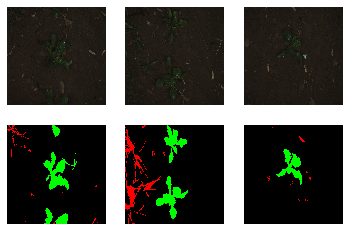

In [3]:

# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the face dataset
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [2]:
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.3)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.3)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.3)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [3]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e2 = Dropout(0.3)(e2)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e4 = Dropout(0.3)(e4)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e6 = Dropout(0.3)(e6)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    b = Dropout(0.3)(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d4 = Dropout(0.3)(d4)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d5 = Dropout(0.3)(d5)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    d7 = Dropout(0.3)(d7)
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [5]:
# load and prepare training images
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [6]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [7]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [8]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [9]:
# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
 
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

In [10]:
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
#train(d_model, g_model, gan_model, dataset)

Loaded (1865, 256, 256, 3) (1865, 256, 256, 3)


In [11]:
dataset = load_real_samples('maps_256test.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

Loaded (387, 256, 256, 3) (387, 256, 256, 3)


In [12]:
g_model.load_weights('model_186500.h5')



In [13]:
xtest, ytest = dataset

In [19]:
xtest.min()

-0.92941177

In [24]:
ytesty=((ytest*127.5)+127.5)/255

In [190]:
ytest1=ytesty[100:200]
xtest1=xtest[100:200]

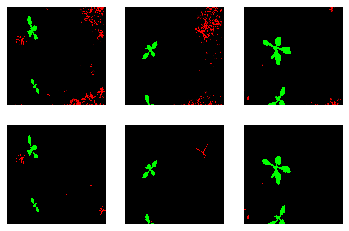

In [29]:
#g_model.load_weights('model_093250.h5')
pred=g_model.predict(xtest)
pred1=(((pred)+1))/2
pred1[pred1<0]=0
pred1[pred>1]=1
for i in range(3):
    pyplot.subplot(2,3,i+1)
    pyplot.axis('off')
    pyplot.imshow(pred1[i+5])
    # plot real target image
for i in range(3):
    pyplot.subplot(2,3,i+4)
    pyplot.axis('off')
    pyplot.imshow(ytesty[i+5])

In [32]:
pred1.min()

0.0

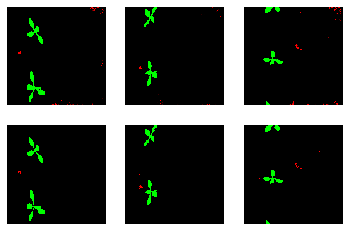

In [22]:
for i in range(3):
    pyplot.subplot(2,3,i+1)
    pyplot.axis('off')
    pyplot.imshow(pred1[i+15])
    # plot real target image
for i in range(3):
    pyplot.subplot(2,3,i+4)
    pyplot.axis('off')
    pyplot.imshow(ytesty[i+15])

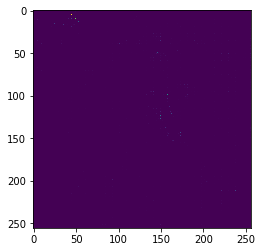

In [31]:
plt.imshow(pred1[123,:,:,2])

In [16]:
import numpy as np
all_iou,meaniou=iou_mean(ytesty[0:50],pred1[0:50])
all_dice,meandice=dice_mean(ytesty[0:50],pred1[0:50])
iouabs=iou_meanabs(ytesty[0:50,:,:,1],pred1[0:50,:,:,1])

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

labels1 = ytesty.flatten()
predictions = pred1.flatten()
print(labels1.max())
print(predictions.max())
print(predictions.min())
print(labels1.min())
tn, fp, fn, tp = confusion_matrix(labels1, predictions,labels=[0,1]).ravel()
#cm = confusion_matrix(labels, predictions)
recall = tp/(tp+fn)
precision = tp/(tp+fp)

In [102]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = (y_true * y_pred)
    union = np.add(y_true,y_pred,axis=(1,2))-intersection
    iou = np.mean((intersection + smooth) / (union + smooth))
    return iou

In [71]:
intersection=np.logical_and(ytesty[0:50,:,:,0],pred1[0:50,:,:,0])
union=np.logical_or(ytesty[0:50,:,:,0],pred1[0:50,:,:,0])
union = union.astype(int)
intersection = intersection.astype(int)
iou=np.mean(np.sum((intersection+1),axis=(1,2))/np.sum((union+1),axis=(1,2)))

In [201]:
y_true=ytest1[:,:,:,2]
y_pred = pred1[:,:,:,2]
intersection = np.multiply(y_true , y_pred)
union = np.add(y_true,y_pred)-intersection
u=np.sum(union)
inter=np.sum(intersection)
iou=(np.sum(intersection)+1)/(np.sum(union)+1)


In [205]:
print(u)
print(inter)
print(iou)
print(y_pred.max())

0.00013266165
0.0
0.9998673559492657
2.2439397e-06


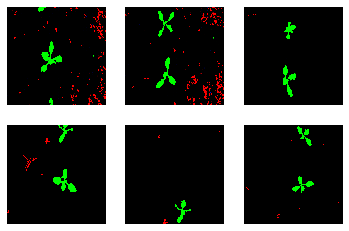

In [167]:
for i in range(40,43):
    pyplot.subplot(2,3,i-40+1)
    pyplot.axis('off')
    pyplot.imshow(pred1[i+40])
    # plot real target image
for i in range(3):
    pyplot.subplot(2,3,i+4)
    pyplot.axis('off')
    pyplot.imshow(ytesty[i+40])

In [ ]:
plt.imshow(pred1[5,:,:,:])

In [ ]:
plt.imshow(ytesty[4])